* Following: http://www.cond-mat.de/teaching/DFT/qm1d.html
* 1D numeric Shrodinger equation solver, by discretisation to an Eigenvalue problem

$$f''(x_i) \approx (f(x_{i-1})-2*f(x_i)+f(x_{i+1}))/dx^2$$

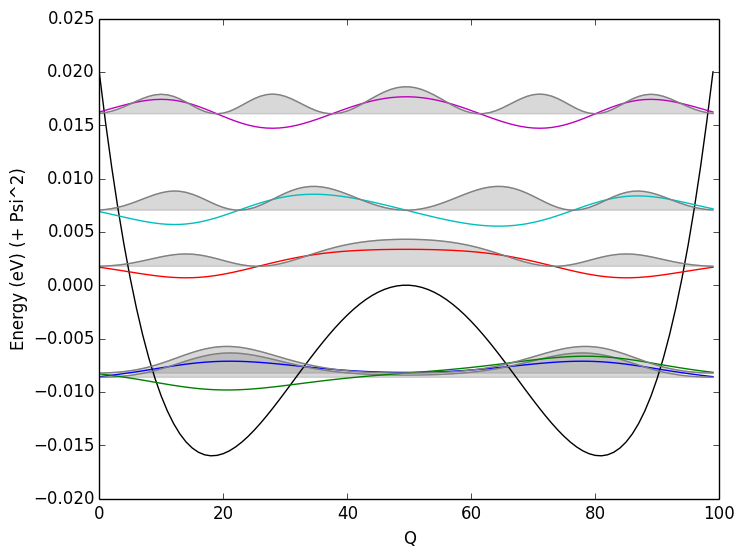

0.0

In [2]:
# Following: http://www.cond-mat.de/teaching/DFT/qm1d.html
# 1D numeric Shrodinger equation solver, by discretisation to an Eigenvalue problem
#  $f''(x_i) \approx (f(x_{i-1})-2*f(x_i)+f(x_{i+1}))/dx^2$

using PyPlot

# Call as:
#  V() - anonymous function to generate potential energy
#  N - discretisation of TISH (and therefore size of matrix to diagonalise)
#  n - number of eigenenergies to plot
function TISH(V,N=99,n=3)
    xlabel("Q")
    ylabel("Energy (eV) (+ Psi^2)")
    plot([V(r) for r in -1.0:2/N:1.0],color="black")    # Potential energy curve
    
    dx=1E2/(N-1) # effectively a Kinetic-Energy term, deciding how closely spaced the energy levels
    
    # PE terms on the trace
    diagonal = [(2.0/dx^2 + V(r))::Float64 for r in -1.0:2/N:1.0]
    
    # KE terms on the tridiagonals
    updiagonal = [(-1/dx^2)::Float64 for r in 1:N]
    H =diagm(diagonal,0) + diagm(updiagonal,1) + diagm(updiagonal,-1)

    # And solve with dense eigensolvers
    evals,evec=eig(H)

    # This many eigenenergies
    for i in 1:n
        # Ψ ; the wavefunction, offset by the eigenvalue
        plot(1E-2.*evec[:,i]+evals[i])
        
        # Ψ^2 , the Prob. density, plotted grey, offset by the eigenvalues
        plot(1E-1.*evec[:,i].^2+evals[i],color="grey")
        # Ψ^2, the prob density, filled curve in semi-tranparent grey, offset + to the eigenvalues
        fill_between(0:N,evals[i],evals[i]+1E-1.*evec[:,i].^2,color="grey",alpha=0.3)
    end
    
    return evals,evec
end

#V(r)=-3/abs(r) #- q^2/()   #... ish
#V(r)=1E-3*r^2  # Harmonic well
#V(r)=0 # infinite well pot.
#V(r)= 0.01*r^2+0.1*r  # an-Harmonic well


#TISH(r->r^2) # Harmonic well
#TISH(r->0) # Infinite well potential.
#TISH(r->3*r^2+r)
#TISH(r->-0.1/abs(r)) # Atom like - 1/r Coulomb potential
#TISH(r->20*r^2-20*abs(r),100,6) # Pretty crummy mexican hat
TISH(r->10E-2*r^4-8E-2*r^2,99,5) # Double well potential; for a 'soft mode' quantum harmonic oscillator phonon instability
#TISH(r->10E-2*r^4,99,20) # Single well potential

0.0 # Stop Eigenvalues / eigvecs being autoprinted


Right - very well! We have a 1D TISH solver.
Now we're going to set up a function to generate a Bose-Einstein distribution, to be able to calculate the occupation of these states in a Quantum Harmonic Oscillator (i.e. phonon populations)

In [3]:
kBeV=8.6173324E-5 # in units of eV

function BE(E,μ=0.0,T=300.0)
    # System specifics + derived quantities
    #T=300           # Temperature; Kelvin
    β=1/(kBeV*T)      # Thermodynamic Beta; units
    1/(exp((E-μ)*β)-1)
end

BE (generic function with 3 methods)

So now, let's get our `evals` and `evecs` from the TISH solver, then integrate over the set of eigenvalues, multiplying each probability density function ($\Psi^2$) with a Bose-Einstein (BE) occupation factor.

We'll set the internal $\mu$ in the BE distribution to a value kbT below the lowest energy level to make it much less infinity, and roughly integrate out to give ~1, but then explicitly normalise the total density to exactly 1. I'm not quite sure what value should be used for $\mu$, it acts as a normalisation constant for the DoS. I assume it is explicitly a chemical potential, but as the population of Phonons changes, this confuses me.

Bose Einstein weight matrix: 0.581977 0.451340 0.299403 0.226114 0.150441 0.095617 0.057497 0.032711 0.017550 0.008854 0.004192 0.001860 0.000773 0.000301 0.000110 0.000038 0.000012 0.000004 0.000001 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 

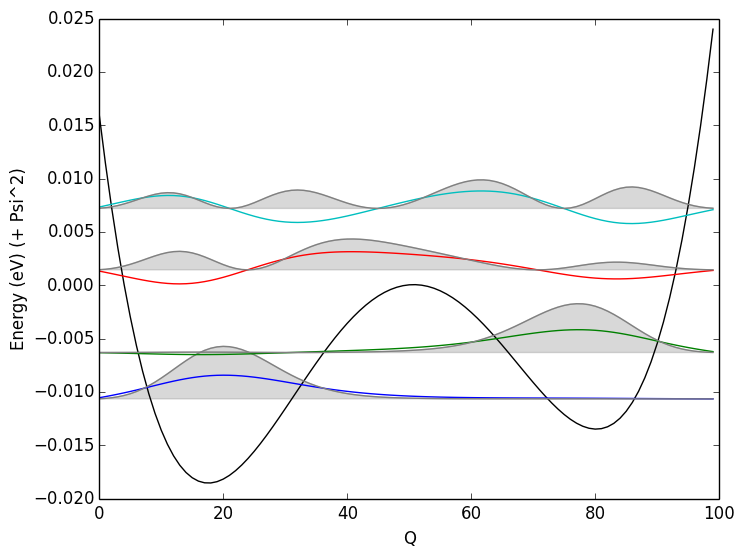

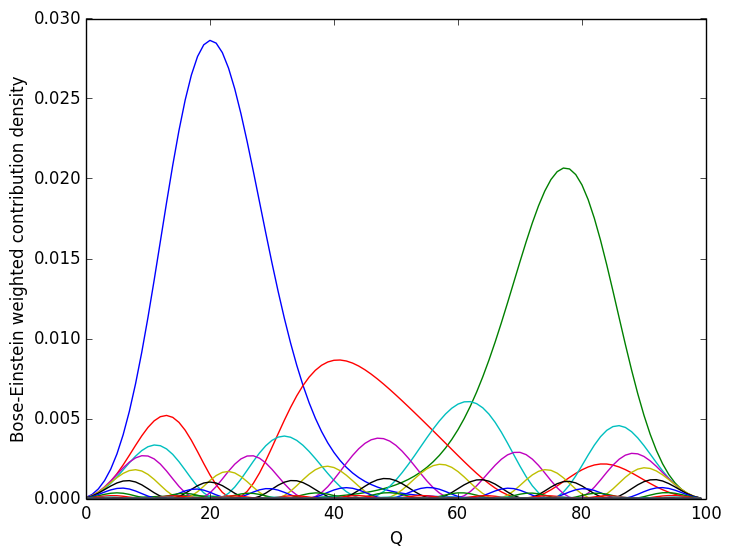

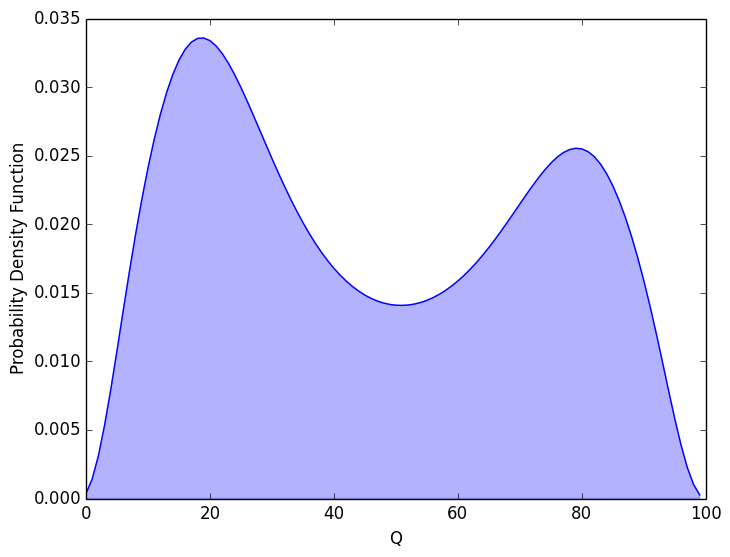

1.9287942885673024

In [4]:
N=99
#evals,evecs=TISH(r->10E-2*r^4-8E-2*r^2,N,4) # Double well potential; for a 'soft mode' quantum harmonic oscillator phonon instability
evals,evecs=TISH(r->10E-2*r^4-8E-2*r^2+4E-3*r,N,4) # Double well potential; with a slant

totaldensity=0.0
@printf("Bose Einstein weight matrix: ")

fig=figure() # new figure please
xlabel("Q")
ylabel("Bose-Einstein weighted contribution density")


for i in 1:length(evals)
#    println(BE(evals[i],evals[1]) )
    T=300
    BEweight=BE(evals[i],evals[1]-kBeV*T,T)
    # alpha set to kbT below the lowest energy level, ~ unitary summation
    @printf("%f ",BEweight)

    # Plot of weighted ψ^2 probability densities 
    plot(BEweight * evecs[:,i].^2)
    # Sum up density
    totaldensity+= (BEweight * evecs[:,i].^2) # Density of this structure
end

fig=figure() # new figure please
plot(totaldensity) # curve of total density
fill_between(0:N,0,totaldensity,color="blue",alpha=0.3) # nice filled curve, partially transparent
xlabel("Q")
ylabel("Probability Density Function")

sum(totaldensity)

1.0 0.9999999999999999 0.9999999999999999 0.9999999999999999 0.9999999999999999 

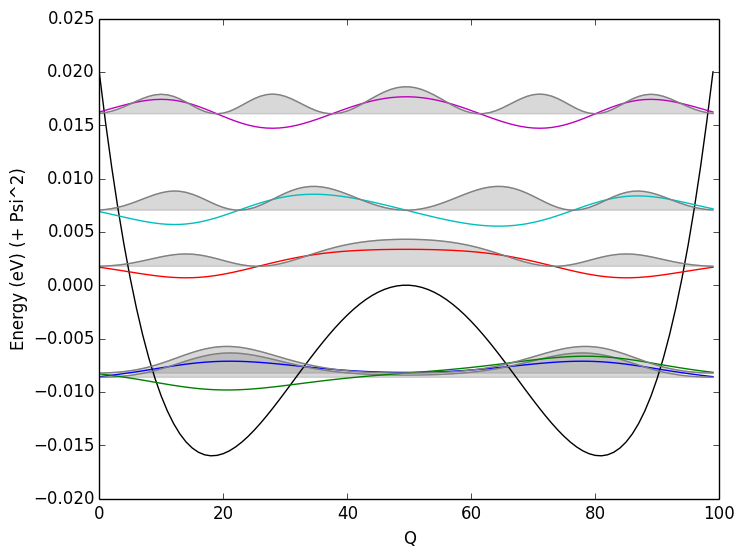

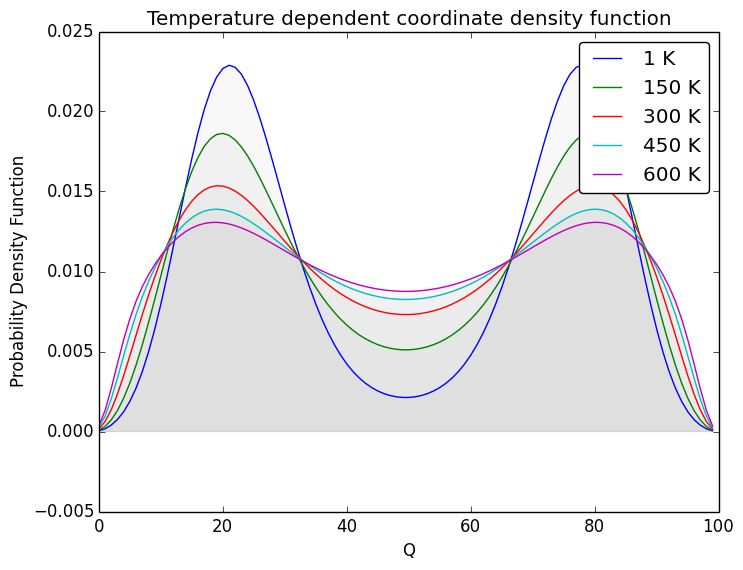

PyObject <matplotlib.legend.Legend object at 0x31ad36b90>

In [7]:
N=99
evals,evecs=TISH(r->10E-2*r^4-8E-2*r^2,N,5) # Double well potential; for a 'soft mode' quantum harmonic oscillator phonon instability
#evals,evecs=TISH(r->10E-2*r^4,N,20) # Single well potential

fig=figure() # new figure please
xlabel("Q")
ylabel("Probability Density Function")
title("Temperature dependent coordinate density function")

# Iterate over these temperatures
for T in [1,150,300,450,600]
    totaldensity=0.0
    for i in 1:length(evals)
        BEweight=BE(evals[i],evals[1]-kBeV*T,T)
        # alpha set to kbT below the lowest energy level, ~ unitary summation

        # Plot of weighted ψ^2 probability densities 
        #plot(BEweight * evecs[:,i].^2)
        # Sum up density
        totaldensity+= (BEweight * evecs[:,i].^2) # Density of this structure
    end
    totaldensity/=sum(totaldensity) # renormalise probability density to ∫ dx =1
    
    # Plot this together in a vaguely pleasant way
    plot(totaldensity,label=@sprintf("%d K",T)) # Plot the PDF, with a label
    fill_between(0:N,0,totaldensity,color="grey",alpha=0.05) # Add a filled curve in grey for PDF, with light alpha
    print(sum(totaldensity)," ") # check normalisation of BE + wavefunction
end
legend(loc="upper right",fancybox="true") # Create a legend of all the existing plots using their labels as names
